
# Skops / scikit-learn model cards

Forsøk på å lage et modellkort med skops for "uføre-diagnose-statisikk-modellen".


In [86]:
import os
import string
import pickle
import random
from pathlib import Path
from tempfile import mkdtemp, mkstemp
from IPython.display import Markdown, display

import pandas as pd
import sklearn
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,roc_curve
)
from sklearn.model_selection import HalvingGridSearchCV, train_test_split

from skops import hub_utils
from skops.card import Card#, metadata_from_configimport
from skops.card import metadata_from_config

%matplotlib inline

## Load digits dataset and create train and test sets

In [114]:
def load_digits_data():
    from sklearn.datasets import load_digits
    from sklearn.model_selection import train_test_split

    X, y = load_digits(as_frame=True, return_X_y=True)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    print("X's summary: ", X.describe())
    print("y's summary: ", y.describe())

    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = load_digits_data()


X's summary:         pixel_0_0    pixel_0_1    pixel_0_2    pixel_0_3    pixel_0_4  \
count     1797.0  1797.000000  1797.000000  1797.000000  1797.000000   
mean         0.0     0.303840     5.204786    11.835838    11.848080   
std          0.0     0.907192     4.754826     4.248842     4.287388   
min          0.0     0.000000     0.000000     0.000000     0.000000   
25%          0.0     0.000000     1.000000    10.000000    10.000000   
50%          0.0     0.000000     4.000000    13.000000    13.000000   
75%          0.0     0.000000     9.000000    15.000000    15.000000   
max          0.0     8.000000    16.000000    16.000000    16.000000   

         pixel_0_5    pixel_0_6    pixel_0_7    pixel_1_0    pixel_1_1  ...  \
count  1797.000000  1797.000000  1797.000000  1797.000000  1797.000000  ...   
mean      5.781859     1.362270     0.129661     0.005565     1.993879  ...   
std       5.666418     3.325775     1.037383     0.094222     3.196160  ...   
min       0.000000   

## Train a Model



In [116]:
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
def train_logistic_regression(X_train, y_train, X_test, y_test, param_grid=None):

    model = HalvingGridSearchCV(
        estimator=LogisticRegression(),
        param_grid=param_grid,
        random_state=42,
        n_jobs=-1,
    ).fit(X_train, y_train)
    
    return model


In [117]:
param_grid = {
    "fit_intercept": [True, False],
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
    "class_weight": [None, "balanced"],
}

model = train_logistic_regression(X_train, y_train, X_test, y_test, param_grid)

print("Best parameters found: ", model.best_params_)
print("Best score found: ", model.best_score_)


/Users/rprabhu/Ana/tadagen/mcardvenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/rprabhu/Ana/tadagen/mcardvenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/rprabhu/Ana/tadagen/mcardvenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/rprabhu/Ana/tadagen/mcardvenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/rprabhu/Ana/tadagen/mcardvenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters found:  {'class_weight': 'balanced', 'fit_intercept': True, 'solver': 'saga'}
Best score found:  0.9582939759036144


/Users/rprabhu/Ana/tadagen/mcardvenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Legg alle nødvendige modellfiler i en mappe
We will now initialize a repository and save our model



In [119]:
model_name = ''.join(random.choices(string.ascii_lowercase +
                             string.digits, k=6))

local_repo = 'models/skops-'+f'{model_name}'
pkl_name = 'models/skops-'+f'{model_name}'+'.pkl'
os.mkdir(f'{local_repo}')

with open(pkl_name, mode="bw") as f:
    pickle.dump(model, file=f)

hub_utils.init(
    model=pkl_name,
    requirements=[f"scikit-learn={sklearn.__version__}"],
    dst=local_repo,
    task="tabular-classification",
    data=X_test,
)

## Lager et modellkort



In [120]:
model_card = Card(model, metadata=metadata_from_config(Path(local_repo)))

card_name = "ModelCard_v01.md"
model_card.save(card_name)
#display(Markdown(card_name))


## Legger til informasjon om modellen i modellkortet

In [133]:
model_card.metadata.license = "MIT"

# MODEL DESCRIPTION
model_description = (
    """
    Modell for produksjon av grunnlagsdata for statistikk på diagnoser for uføretrygdede. 
    Modellene benytter numeriske features fra TF-idf vektorisering av fritekstfelter i medisinske dokumenter. 
    
    
    *Utfall*: Predikert *diagnosegruppe-kode* gitt tekstinnhold i grunnlagsdokumenter.

    *Type*: Klassifisering, Logistisk regresjon

    *Læringsmetode*: Veiledet læring

    *Inngår personopplysninger?*: JA

    """
)

# BRUK
bruk = """
Modellen er kun tiltenkt bruk i produksjon av offentlig statikk for 
[diagnoser på uføretrygd](https://www.nav.no/no/nav-og-samfunn/statistikk/aap-nedsatt-arbeidsevne-og-uforetrygd-statistikk/uforetrygd/diagnoser-uforetrygd)
"""


# DATAGRUNNLAG
datagrunnlag = """
Medisinske dokumenter for alle nye uføretrygdede i perioden 2013-2016. 
Dokumentene er skrevet av tredjeparter (f.eks. leger) og samlet inn gjennom sykemeldings- og AAP-løp.

*Primærkilde(r)*: JOARK
"""

# VALG AV MODELL
valg_av_modell = """ 
Klassifisering vha `LogisticRegression`. 
Modellen er valgt fordi den representerer en enkel, rask og forklarbar modell for klassifisering av tabulære data.

*Er modellen egenutviklet i Nav eller brukes modell utenifra?*: Egenutviklet  

""" 

# PARENT MODEL
parent_model = "None"

# EVALUERING
model_evaluering = """

*Hvilke metrikker er brukt for å vurdere modellens treffsikkerhet?*:\n *accuracy* og *F1-score* (se detaljer under) 

*Hva er definisjonen av suksess?*:\n Riktig klassifisering 

*Hvordan treffer modellen forskjellige undergrupper?* : \n Modellen er best på de største diagnosegruppene i treningsgrunnlaget.  
Features i modellen er utelukkende tekst, så har ikke evaluert for eksempel hvordan demografiske grupper slår ut mtp feilklassifisering 

*Hvordan har du gått fram for å forstå hvorfor modellen predikerer som den gjør?*:\n  Produsert statistikk på prediksjon vs observert verdi 

*Hvordan har du tenkt på modellsikkerhet?*:\n  Ingen særskilte vurderinger.

*CO2-utslipp?*:\n Ikke vurdert.

"""

# LIMITATIONS
limitations = """

*Hvilke kjente begrensninger har modellen?*:\n  Modellen viser særlige svakheter overfor *ICD-gruppe T* (Skader ol.) 

*Kjente risikoer ved å ta i bruk denne modellen?*:\n  Trent på diagnosekodeverk som skal erstattes.  

*Hvilke anbefalinger har du når modellen tas i bruk?*:\n 

 - Må retrenes  
 - Datakvalitet må sjekkes bedre
- Kode må optimaliseres 
"""

# WHO MADE IT?
model_card_authors = "Team TADA, PO xyz"
model_card_contact = "**Slack**: #tada, **epost**: ta-kontakt-med-oss@nav.no"
citation_bibtex = "**Etterlevelse**: etterlevelse.intern.nav.no```"



# ADD IT ALL TO THE CARD
model_card.add(
    **{
        "Model description": model_description,
        "Model description/Intended uses & limitations": bruk,
        "Model description/Intended uses & limitations": limitations,
        "Model description/Training Procedure": datagrunnlag,
        "Valg av modell":valg_av_modell,
        "Parent model": parent_model,
        "Model description/Evaluation Results": model_evaluering,

        "Citation": citation_bibtex,
        "Model Card Authors": model_card_authors,
        "Model Card Contact": model_card_contact,
    }
)

Card(
  model=HalvingGridSearchCV(estimator=L...', 'sag', 'saga']}, random_state=42),
  metadata.license=MIT,
  metadata.library_name=sklearn,
  metadata.tags=['sklearn', 'skops', 'tabular-classification'],
  metadata.model_format=pickle,
  metadata.model_file=skops-rvunsg.pkl,
  metadata.widget=[{...}],
  Model description= Modell for produks...ng *Inngår personopplysninger?*: JA ,
  Model description/Intended uses & lim...ekkes bedre - Kode må optimaliseres ,
  Model description/Training Procedure=...og AAP-løp. *Primærkilde(r)*: JOARK ,
  Model description/Training Procedure/Hyperparameters=TableSection(30x2),
  Model description/Training Procedure/...</div></div></div></div></div></div>,
  Model description/Evaluation Results=...nger. *CO2-utslipp?*: Ikke vurdert. ,
  Model description/Evaluation Results/...ix=PlotSection(confusion_matrix.png),
  Model description/Evaluation Results/...r search results=TableSection(30x25),
  Model description/Evaluation Results/...sification report

## Add plots, metrics, and tables to our model card
Furthermore, to better understand the model performance, we should evaluate it
on certain metrics and add those evaluations to the model card. In this
particular example, we want to calculate the accuracy and the F1 score. We
calculate those using sklearn and then add them to the model card by calling
:meth:`.Card.add_metrics`. But this is not all, we can also add matplotlib
figures to the model card, e.g. a plot of the confusion matrix. To achieve
this, we create the plot using sklearn, save it locally, and then add it using
:meth:`.Card.add_plot` method. Finally, we can also add some useful tables to
the model card, e.g. the results from the grid search and the classification
report. Those can be added using :meth:`.Card.add_table`



Card(
  model=HalvingGridSearchCV(estimator=L...', 'sag', 'saga']}, random_state=42),
  metadata.license=MIT,
  metadata.library_name=sklearn,
  metadata.tags=['sklearn', 'skops', 'tabular-classification'],
  metadata.model_format=pickle,
  metadata.model_file=skops-rvunsg.pkl,
  metadata.widget=[{...}],
  Model description= Modell for produks...ng *Inngår personopplysninger?*: JA ,
  Model description/Intended uses & lim...ekkes bedre - Kode må optimaliseres ,
  Model description/Training Procedure=...og AAP-løp. *Primærkilde(r)*: JOARK ,
  Model description/Training Procedure/Hyperparameters=TableSection(30x2),
  Model description/Training Procedure/...</div></div></div></div></div></div>,
  Model description/Evaluation Results=TableSection(2x2),
  Model description/Evaluation Results/...ix=PlotSection(confusion_matrix.png),
  Model description/Evaluation Results/...r search results=TableSection(30x25),
  Model description/Evaluation Results/...sification report=TableSection(12x5),
 

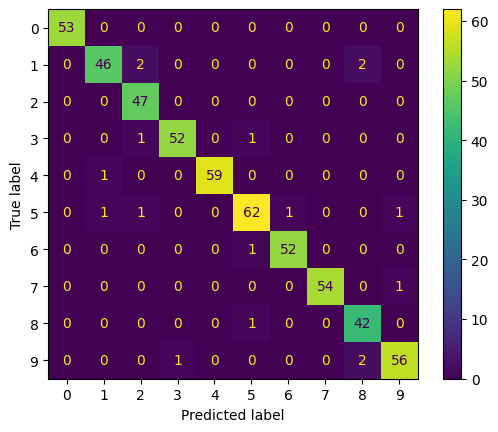

In [134]:
y_pred = model.predict(X_test)

# ADD AN EVALUATION
eval_descr = (
    "Modellen er primært evaluert på test data og optimert for *accuracy* og *F1-score* med 'macro' som gjennomsnittsmetode."
)
model_card.add(**{"Evalueringsresultater": eval_descr})



# ADD A METRIC
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="macro")


model_card.add_metrics(**{"accuracy": accuracy, "f1 score": f1 })

# ADD A PLOT
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

#disp.figure_.savefig(Path(local_repo) / "confusion_matrix.png")
disp.figure_.savefig(Path("confusion_matrix.png"))
model_card.add_plot(
    **{"Model description/Evaluation Results/Confusion Matrix": "confusion_matrix.png"}
)



# ADD A TABLE
cv_results = model.cv_results_
clf_report = classification_report(
    y_test, y_pred, output_dict=True, target_names=["Diag{}".format(val) for val in model.classes_]#["malignant", "benign"]
)
# The classification report has to be transformed into a DataFrame first to have
# the correct format. This requires removing the "accuracy", which was added
# above anyway.
del clf_report["accuracy"]
clf_report = pd.DataFrame(clf_report).T.reset_index()
model_card.add_table(
    folded=True,
    **{
        "Model description/Evaluation Results/Hyperparameter search results": cv_results,
        "Model description/Evaluation Results/Classification report": clf_report,
    },
)

## Save model card
We can simply save our model card by providing a path to :meth:`.Card.save`.



In [135]:
model_card.save(card_name)